In [2]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import time

## 3
(by hand) Verify that the minimizer satisfies the sufficient optimality conditions. (Hint: you can compute eigenvalues of a matrix in Matlab using the command eig).

In [11]:
f = lambda x, y: 100*(y - x**2)**2 + (1 - x)**2
df = lambda x, y: np.array([-400*(-x**2 + y)*x - 2 + 2*x, 200 * (y - x**2)])
ddf = lambda x, y: np.array([[1200*x**2 - 400*y + 2, -400*x], [-400*x, 200]])

The sufficient optimality conditions for a minimizer are
$$\nabla f(x^*) = 0$$
$$\nabla^2 f(x^*) \succ 0$$
with $x^* = (1, 1)^T$.

In [38]:
print("The gradient to the minimizer is ", df(1,1))
print("The hessian to the minimizer is \n", ddf(1,1))

The gradient to the minimizer is  [0 0]
The hessian to the minimizer is 
 [[ 802 -400]
 [-400  200]]


In [34]:
eigs = np.linalg.eig(ddf(1,1))
print("The eigenvalues of the hessian are ", eigs[0])
print("The eigenvectors of the hessian are \n", eigs[1])

The eigenvalues of the hessian are  [1.00160064e+03 3.99360767e-01]
The eigenvectors of the hessian are 
 [[ 0.89478425  0.44649877]
 [-0.44649877  0.89478425]]


And we can see that the hessian has only positive eigenvalues and is therefore positive definite, meaning that the sufficient optimality conditions are satisfied.

## 4 - 6

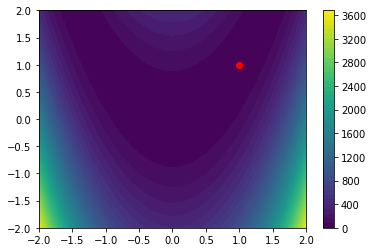

In [31]:
def create_contour_sympy(expression, symbs, xlim, ylim, lvls):
    # Sympy expression needed
    # With symbols of the expression
    func = sp.lambdify(symbs, expression, modules=['numpy'])
    x1_vals = np.linspace(xlim[0], xlim[1], 500)
    x2_vals = np.linspace(ylim[0], ylim[1], 500)
    X, Y = np.meshgrid(x1_vals, x2_vals)
    Z = func(X, Y)
    if len(Z.shape) == 4:
        Z = Z[0,0]
    return plt.contourf(X, Y, Z, levels=lvls)  # You can adjust the number of contour levels

x,y = sp.symbols("x y")
expr = 100*(y - x**2)**2 + (1 - x)**2

cont = create_contour_sympy(expr, (x,y), (-2,2), (-2,2), 50)
plt.plot(1,1, 'ro')
plt.colorbar(cont)

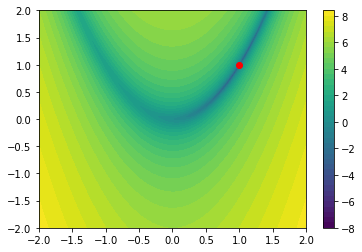

In [32]:
cont = create_contour_sympy(sp.log(expr), (x,y), (-2,2), (-2,2), 50)
plt.plot(1,1, 'ro')
plt.colorbar(cont)

The two plots convey the same information, however, the scale makes it quite hard to see. The log plot conveys the information better, as we are working with very small values otherwise.

## 7

In [231]:
def steepest_descent(f, fd, x0, tol, max_iter,alpha=1, backtrack = True):
    xstar = np.array([1,1])
    c = 0.8
    rho = 0.5

    x = np.array(x0)

    stats = {'k': [0], 'fxk': [f(*x)], 'ek': [np.linalg.norm(xstar - x)], 'alphak': [alpha], 'xk': [x], 'x_star': 0}

    for i in range(max_iter):
        pk = -fd(*x)/np.linalg.norm(fd(*x))

        if backtrack:
            alpha = 1
            left = f(*(x + alpha * pk))
            right = f(*x) - c*alpha*fd(*x).T@pk
            # Backtracking - evaluate function at each half-decreasing alpha
            while left > right:
                alpha = alpha*rho
                left = f(*(x + alpha* pk))


        x = x - alpha* (fd(*x)/np.linalg.norm(fd(*x)))
        stats['k'].append(i+1)
        stats['fxk'].append(f(*x))
        stats['ek'].append(np.linalg.norm(xstar - x))
        stats['alphak'].append(alpha)
        stats['xk'].append(x)
        if np.linalg.norm(fd(*x)) < tol:
            stats["x_star"] = x
            print("Converged!")
            break

    if stats["x_star"] == 0:
        print("Didn't converge!")
        stats["x_star"] = stats["xk"][-1]
    return stats

In [232]:
logf = lambda x, y: np.log(100*(y - x**2)**2 + (1 - x)**2)
logdf = lambda x, y: np.array([(-400*(-x**2 + y)*x - 2 + 2 * x)/(100*(y - x**2)**2 + (1-x)**2), (200 * (y - x**2))/(100*(y - x**2)**2 + (1-x)**2)])

Didn't converge!


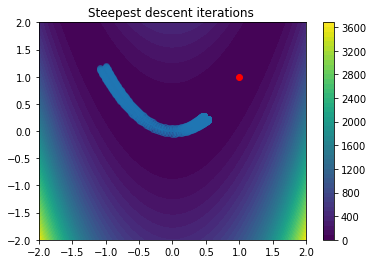

Text(0.5, 1.0, 'Step size')

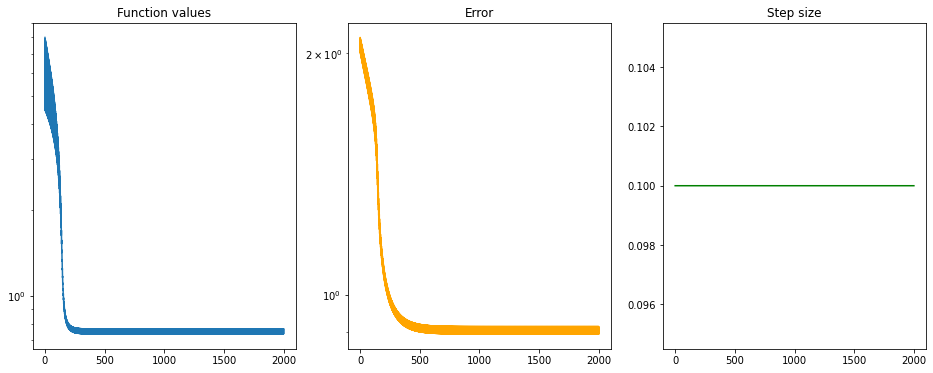

In [238]:
SD_stats = steepest_descent(f, df, [-1,1.2], 1e-8, 2000, alpha=0.1, backtrack = False)

cont = create_contour_sympy(expr, (x,y), (-2,2), (-2,2), 50)
plt.plot(1,1, 'ro')
plt.colorbar(cont)
plt.title("Steepest descent iterations ")
plt.plot([x[0] for x in SD_stats["xk"]], [x[1] for x in SD_stats["xk"]], 'o-', alpha=0.5)
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,6))
ax1.semilogy(SD_stats["k"], SD_stats["fxk"])
#ax1.legend(["$f(x_k)$"])
ax1.set_title("Function values")

ax2.semilogy(SD_stats["k"], SD_stats["ek"], c="orange")
#ax2.legend(["$e_k$"])
ax2.set_title("Error")

ax3.plot(SD_stats["k"], SD_stats["alphak"], c="green")
#ax3.legend(["$\\alpha_k$"])
ax3.set_title("Step size")

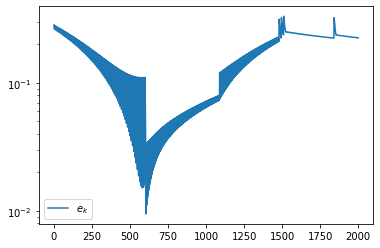

In [224]:
plt.semilogy(SD_stats["k"], SD_stats["ek"])
plt.legend(["$e_k$"])

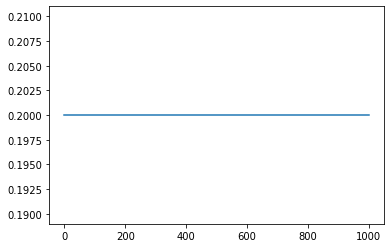

In [104]:
plt.plot(SD_stats["k"], SD_stats["alphak"])

In [205]:
np.linalg.eig(np.array([[0,-1],[-1,0]]))

(array([ 1., -1.]),
 array([[ 0.70710678,  0.70710678],
        [-0.70710678,  0.70710678]]))